#**Pré-processamento**

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

import pandas as pd
import seaborn as sns
import missingno as msno
import warnings
from matplotlib import pyplot as plt
import datetime
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',100)

df = pd.read_csv("gdrive/My Drive/dissertação/Qualidade_do_ar_-_Dados_horarios.csv",sep=",")
df['Data']=df['Data'].astype('str')
df['Data']=df['Data'].apply(lambda x: x[:-3])

#conversão para datetime
def convert_to_datetime(x):
    return(datetime.datetime.strptime(x, "%Y/%m/%d %H:%M:%S"))
df['Data']=df['Data'].apply(convert_to_datetime) 
df['Hora-minuto']=df['Data'].apply(lambda x: str(x)[-8:-3])
# #extrair ano, mes, hora 
df['Ano']=df['Data'].apply(lambda x: x.year)
df['Mês']=df['Data'].apply(lambda x: x.month)
df['Dia']=df['Data'].apply(lambda x: x.day)
df['Hora']=df['Data'].apply(lambda x: x.hour)
df['Hora-minuto']=df['Data'].apply(lambda x: str(x)[-11:-6])

df_bg=df[df['Estação']=='BG'] #Bangu
df_gc=df[df['Estação']=='CG'] #Campo Grande
df_ca=df[df['Estação']=='CA'] #Centro
df_av=df[df['Estação']=='AV'] #Copacabana
df_ir=df[df['Estação']=='IR'] #Irajá
df_pg=df[df['Estação']=='PG'] #Pedra de Guaratiba
df_sc=df[df['Estação']=='SC'] #São Cristóvão
df_sp=df[df['Estação']=='SP'] #Tijuca

df_sc.set_index('Data',inplace=True)
df_sc.drop(columns=['OBJECTID','CodNum','Estação','Dir_Vento','NO2','HCNM','HCT','CH4','NO','NOx',\
                   'PM2_5', 'Lat', 'Lon', 'X_UTM_Sirgas2000','Y_UTM_Sirgas2000'], inplace=True)
df_sc_2=df_sc.copy() #para fazer distribuição sem eliminar ausentes

df_sc=df_sc['2011-01-01':'2018-01-01']
#explicar que usou interpolação linear com spline e justificar
df_sc['Chuva'].interpolate(method='slinear', inplace=True)
df_sc['Pres'].interpolate(method='slinear', inplace=True)
df_sc['RS'].interpolate(method='slinear', inplace=True)
df_sc['Temp'].interpolate(method='slinear', inplace=True)
df_sc['UR'].interpolate(method='slinear', inplace=True)
df_sc['Vel_Vento'].interpolate(method='slinear', inplace=True)
df_sc['SO2'].interpolate(method='slinear', inplace=True)
df_sc['CO'].interpolate(method='slinear', inplace=True)
df_sc['O3'].interpolate(method='slinear', inplace=True)
df_sc['PM10'].interpolate(method='slinear', inplace=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#**(spline) LAG=1**

In [ ]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score #colocar citação

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

df_sc.drop(columns=['Ano','Mês','Dia','Hora','Hora-minuto'], inplace=True)
#df_sc.drop(columns=['Hora-minuto'], inplace=True)
df_sc_copy=df_sc.copy()
df_sc_copy=df_sc_copy[['O3']]
df_sc.drop(columns=['O3'],inplace=True)
df_sc = pd.concat([df_sc_copy,df_sc], axis=1, ignore_index=False)

values = df_sc.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# specify the number of lag hours
n_hours = 1
n_features = 10

# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

# split into train and test sets
values = reframed.values
n_train_hours = 1855 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

# design network
opt = Adam(learning_rate=0.0005)
model = Sequential()
model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer=opt)

# fit network
history = model.fit(train_X, train_y, epochs=300, batch_size=500, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/300
90/90 - 1s - loss: 0.0544 - val_loss: 0.0376
Epoch 2/300
90/90 - 0s - loss: 0.0365 - val_loss: 0.0334
Epoch 3/300
90/90 - 0s - loss: 0.0318 - val_loss: 0.0311
Epoch 4/300
90/90 - 0s - loss: 0.0291 - val_loss: 0.0292
Epoch 5/300
90/90 - 0s - loss: 0.0279 - val_loss: 0.0278
Epoch 6/300
90/90 - 0s - loss: 0.0271 - val_loss: 0.0273
Epoch 7/300
90/90 - 0s - loss: 0.0265 - val_loss: 0.0270
Epoch 8/300
90/90 - 0s - loss: 0.0261 - val_loss: 0.0269
Epoch 9/300
90/90 - 0s - loss: 0.0259 - val_loss: 0.0266
Epoch 10/300
90/90 - 0s - loss: 0.0257 - val_loss: 0.0265
Epoch 11/300
90/90 - 0s - loss: 0.0256 - val_loss: 0.0264
Epoch 12/300
90/90 - 0s - loss: 0.0254 - val_loss: 0.0264
Epoch 13/300
90/90 - 0s - loss: 0.0254 - val_loss: 0.0262
Epoch 14/300
90/90 - 0s - loss: 0.0253 - val_loss: 0.0262
Epoch 15/300
90/90 - 0s - loss: 0.0252 - val_loss: 0.0262
Epoch 16/300
90/90 - 0s - loss: 0.0251 - val_loss: 0.0261
Epoch 17/300
90/90 - 0s - loss: 0.0251 - val_loss: 0.0260
Epoch 18/300
90/90 - 0s

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -9:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -9:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 9.627


In [ ]:
# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test MAE: 6.016


In [ ]:
# calculate R2
r2=r2_score(inv_y, inv_yhat)
print('Test R2: %.3f' % r2)

Test R2: 0.838


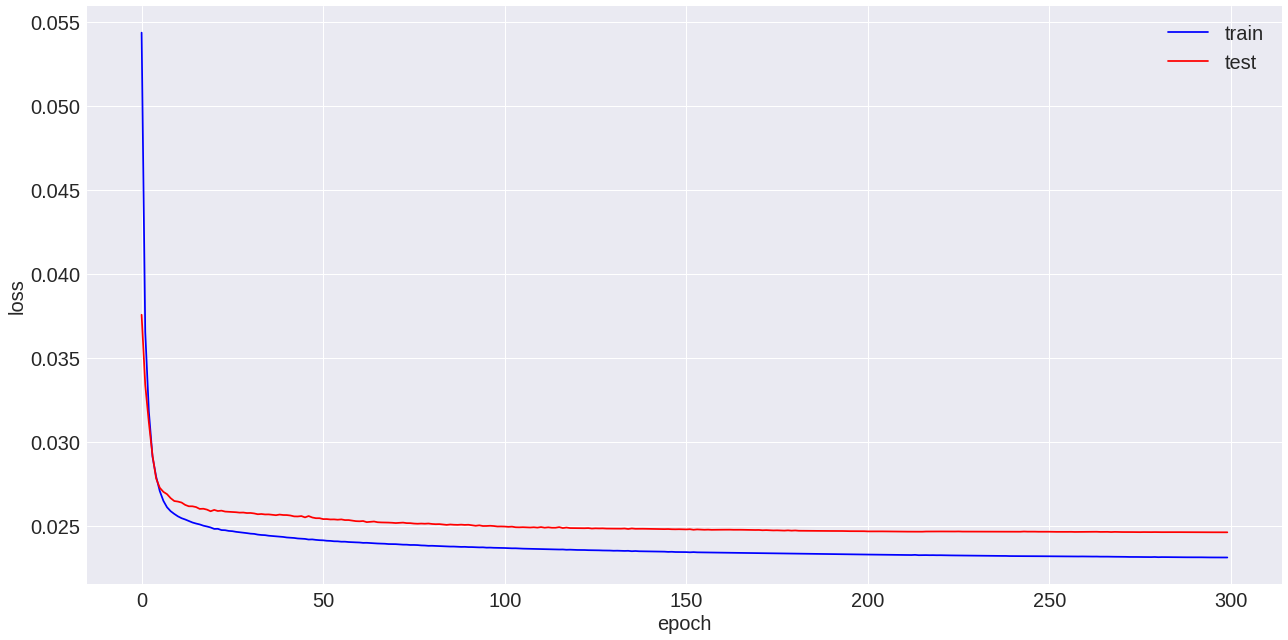

In [ ]:
# plot history
plt.style.use('seaborn')
plt.figure(figsize=(18,9))
pyplot.plot(history.history['loss'], label='train', color='blue')
pyplot.plot(history.history['val_loss'], label='test', color='red')
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss',fontsize=20) 
# plt.title('train and test loss evolution',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
pyplot.legend(fontsize=20)
pyplot.show()

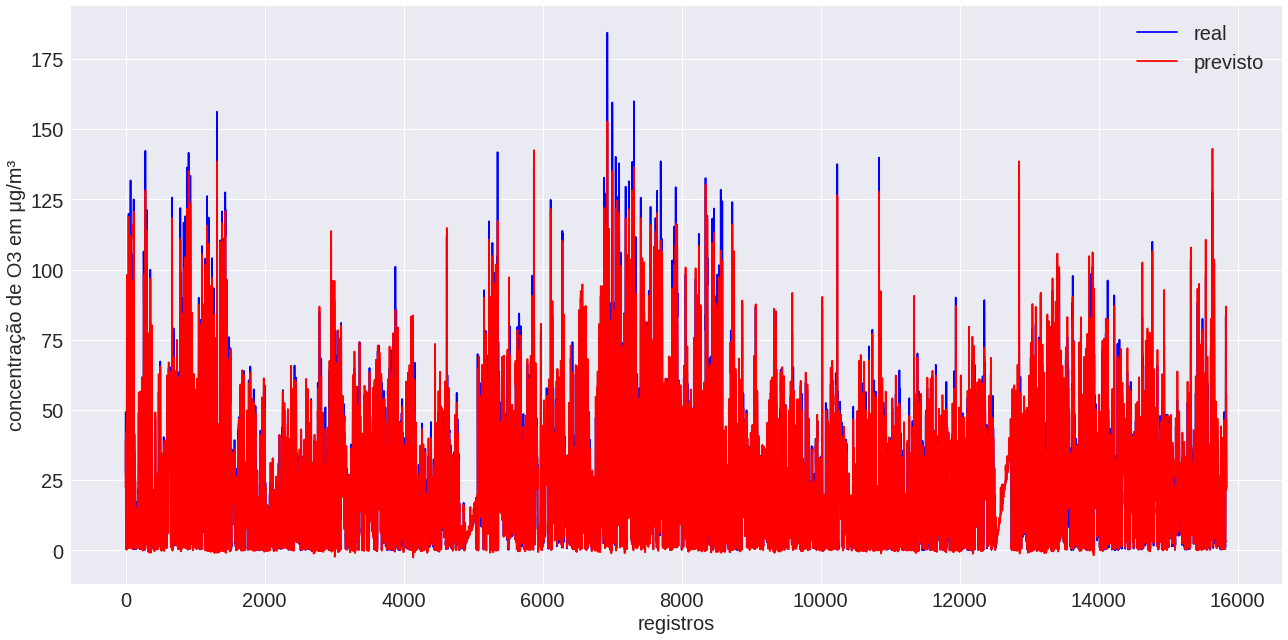

In [ ]:
# plot history
plt.style.use('seaborn')
plt.figure(figsize=(18,9))
pyplot.plot(inv_y, label='real', color='blue')
pyplot.plot(inv_yhat, label='previsto', color='red')
plt.xlabel('registros',fontsize=20)
plt.ylabel('concentração de O3 em μg/m³',fontsize=20) 
# plt.title('comparação: real vs previsto',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
pyplot.legend(fontsize=20)
pyplot.show()

#**(spline) LAG=2**

In [ ]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score #colocar citação

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

df_sc.drop(columns=['Ano','Mês','Dia','Hora','Hora-minuto'], inplace=True)
#df_sc.drop(columns=['Hora-minuto'], inplace=True)
df_sc_copy=df_sc.copy()
df_sc_copy=df_sc_copy[['O3']]
df_sc.drop(columns=['O3'],inplace=True)
df_sc = pd.concat([df_sc_copy,df_sc], axis=1, ignore_index=False)

values = df_sc.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# specify the number of lag hours
n_hours = 2
n_features = 10

# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 2)

# split into train and test sets
values = reframed.values
n_train_hours = 1855 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

# design network
opt = Adam(learning_rate=0.0005)
model = Sequential()
model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer=opt)

# fit network
history = model.fit(train_X, train_y, epochs=300, batch_size=500, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/300
90/90 - 1s - loss: 0.0538 - val_loss: 0.0500
Epoch 2/300
90/90 - 0s - loss: 0.0462 - val_loss: 0.0438
Epoch 3/300
90/90 - 0s - loss: 0.0433 - val_loss: 0.0422
Epoch 4/300
90/90 - 0s - loss: 0.0416 - val_loss: 0.0413
Epoch 5/300
90/90 - 0s - loss: 0.0404 - val_loss: 0.0405
Epoch 6/300
90/90 - 0s - loss: 0.0394 - val_loss: 0.0398
Epoch 7/300
90/90 - 0s - loss: 0.0386 - val_loss: 0.0390
Epoch 8/300
90/90 - 0s - loss: 0.0379 - val_loss: 0.0382
Epoch 9/300
90/90 - 0s - loss: 0.0373 - val_loss: 0.0377
Epoch 10/300
90/90 - 0s - loss: 0.0368 - val_loss: 0.0372
Epoch 11/300
90/90 - 0s - loss: 0.0365 - val_loss: 0.0369
Epoch 12/300
90/90 - 0s - loss: 0.0362 - val_loss: 0.0366
Epoch 13/300
90/90 - 0s - loss: 0.0360 - val_loss: 0.0364
Epoch 14/300
90/90 - 0s - loss: 0.0358 - val_loss: 0.0363
Epoch 15/300
90/90 - 0s - loss: 0.0357 - val_loss: 0.0362
Epoch 16/300
90/90 - 0s - loss: 0.0356 - val_loss: 0.0361
Epoch 17/300
90/90 - 0s - loss: 0.0355 - val_loss: 0.0361
Epoch 18/300
90/90 - 0s

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -9:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -9:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 13.175


In [ ]:
# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test MAE: 8.433


In [ ]:
# calculate R2
r2=r2_score(inv_y, inv_yhat)
print('Test R2: %.3f' % r2)

Test R2: 0.696


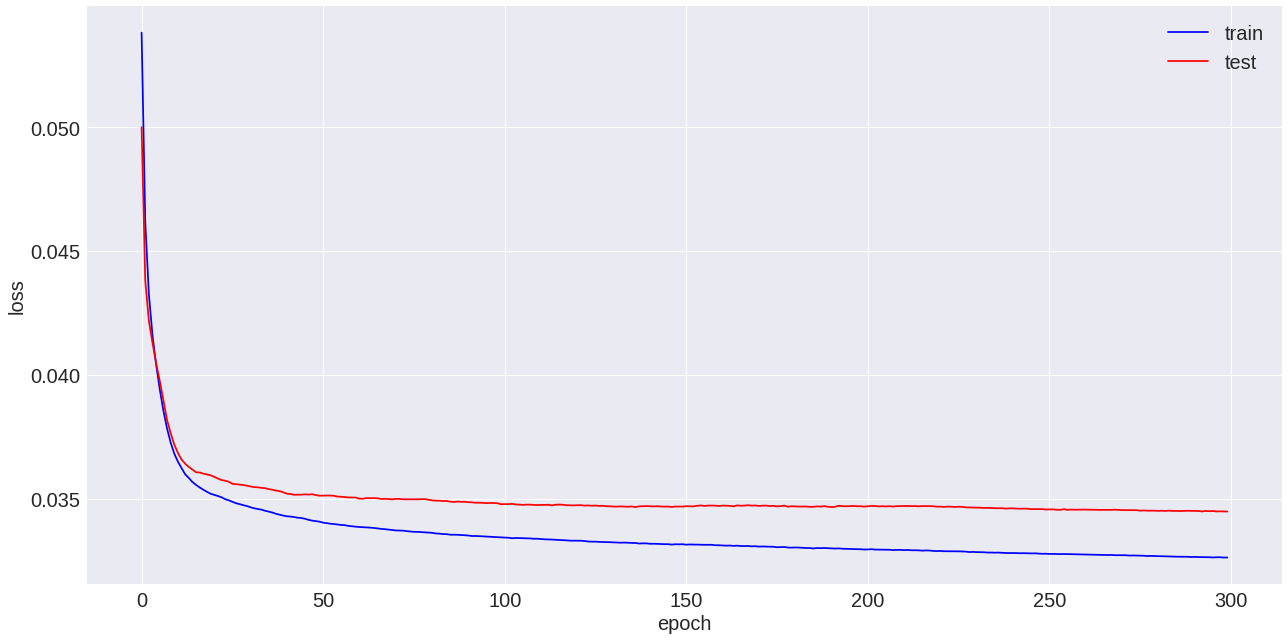

In [ ]:
# plot history
plt.style.use('seaborn')
plt.figure(figsize=(18,9))
pyplot.plot(history.history['loss'], label='train', color='blue')
pyplot.plot(history.history['val_loss'], label='test', color='red')
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss',fontsize=20) 
# plt.title('train and test loss evolution',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
pyplot.legend(fontsize=20)
pyplot.show()

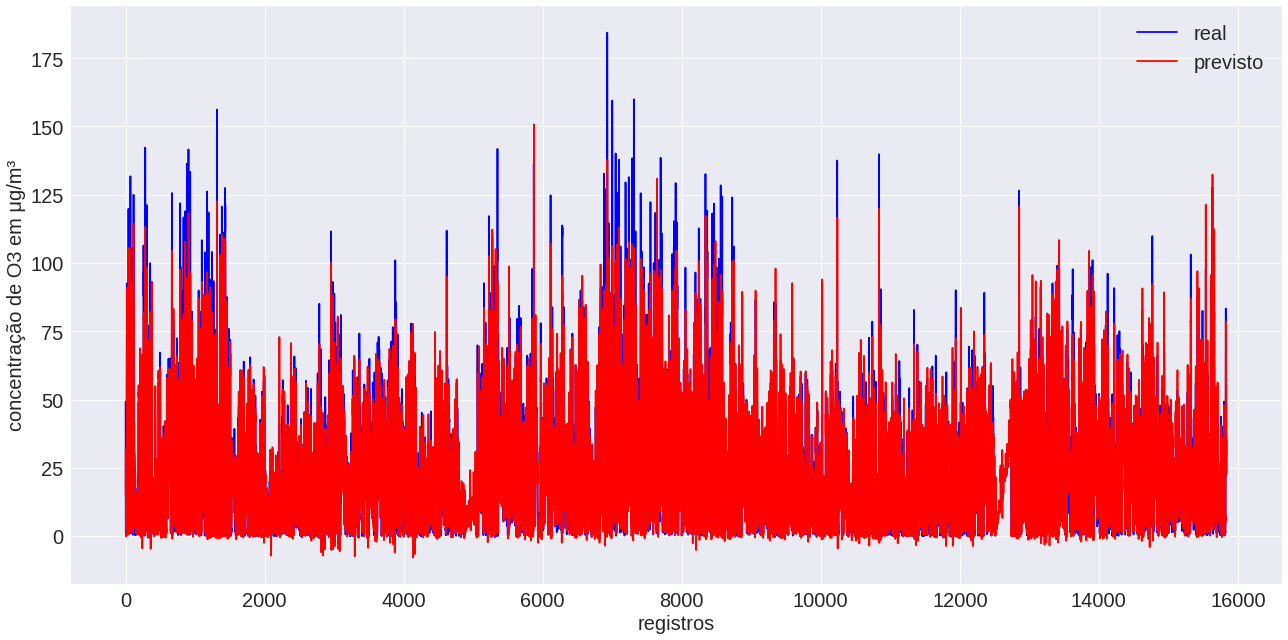

In [ ]:
# plot history
plt.style.use('seaborn')
plt.figure(figsize=(18,9))
pyplot.plot(inv_y, label='real', color='blue')
pyplot.plot(inv_yhat, label='previsto', color='red')
plt.xlabel('registros',fontsize=20)
plt.ylabel('concentração de O3 em μg/m³',fontsize=20) 
# plt.title('comparação: real vs previsto',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
pyplot.legend(fontsize=20)
pyplot.show()

#**(spline) LAG=3**

In [ ]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score #colocar citação

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

df_sc.drop(columns=['Ano','Mês','Dia','Hora','Hora-minuto'], inplace=True)
#df_sc.drop(columns=['Hora-minuto'], inplace=True)
df_sc_copy=df_sc.copy()
df_sc_copy=df_sc_copy[['O3']]
df_sc.drop(columns=['O3'],inplace=True)
df_sc = pd.concat([df_sc_copy,df_sc], axis=1, ignore_index=False)

values = df_sc.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# specify the number of lag hours
n_hours = 3
n_features = 10

# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 3)

# split into train and test sets
values = reframed.values
n_train_hours = 1855 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

# design network
opt = Adam(learning_rate=0.0005)
model = Sequential()
model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer=opt)

# fit network
history = model.fit(train_X, train_y, epochs=300, batch_size=500, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/300
90/90 - 1s - loss: 0.0655 - val_loss: 0.0561
Epoch 2/300
90/90 - 0s - loss: 0.0546 - val_loss: 0.0535
Epoch 3/300
90/90 - 0s - loss: 0.0518 - val_loss: 0.0512
Epoch 4/300
90/90 - 0s - loss: 0.0491 - val_loss: 0.0491
Epoch 5/300
90/90 - 0s - loss: 0.0471 - val_loss: 0.0473
Epoch 6/300
90/90 - 0s - loss: 0.0456 - val_loss: 0.0457
Epoch 7/300
90/90 - 0s - loss: 0.0448 - val_loss: 0.0448
Epoch 8/300
90/90 - 0s - loss: 0.0442 - val_loss: 0.0444
Epoch 9/300
90/90 - 0s - loss: 0.0437 - val_loss: 0.0441
Epoch 10/300
90/90 - 0s - loss: 0.0434 - val_loss: 0.0439
Epoch 11/300
90/90 - 0s - loss: 0.0431 - val_loss: 0.0437
Epoch 12/300
90/90 - 0s - loss: 0.0429 - val_loss: 0.0435
Epoch 13/300
90/90 - 0s - loss: 0.0427 - val_loss: 0.0434
Epoch 14/300
90/90 - 0s - loss: 0.0425 - val_loss: 0.0433
Epoch 15/300
90/90 - 0s - loss: 0.0424 - val_loss: 0.0432
Epoch 16/300
90/90 - 0s - loss: 0.0422 - val_loss: 0.0430
Epoch 17/300
90/90 - 0s - loss: 0.0421 - val_loss: 0.0429
Epoch 18/300
90/90 - 0s

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -9:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -9:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 14.872


In [ ]:
# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test MAE: 9.749


In [ ]:
# calculate R2
r2=r2_score(inv_y, inv_yhat)
print('Test R2: %.3f' % r2)

Test R2: 0.613


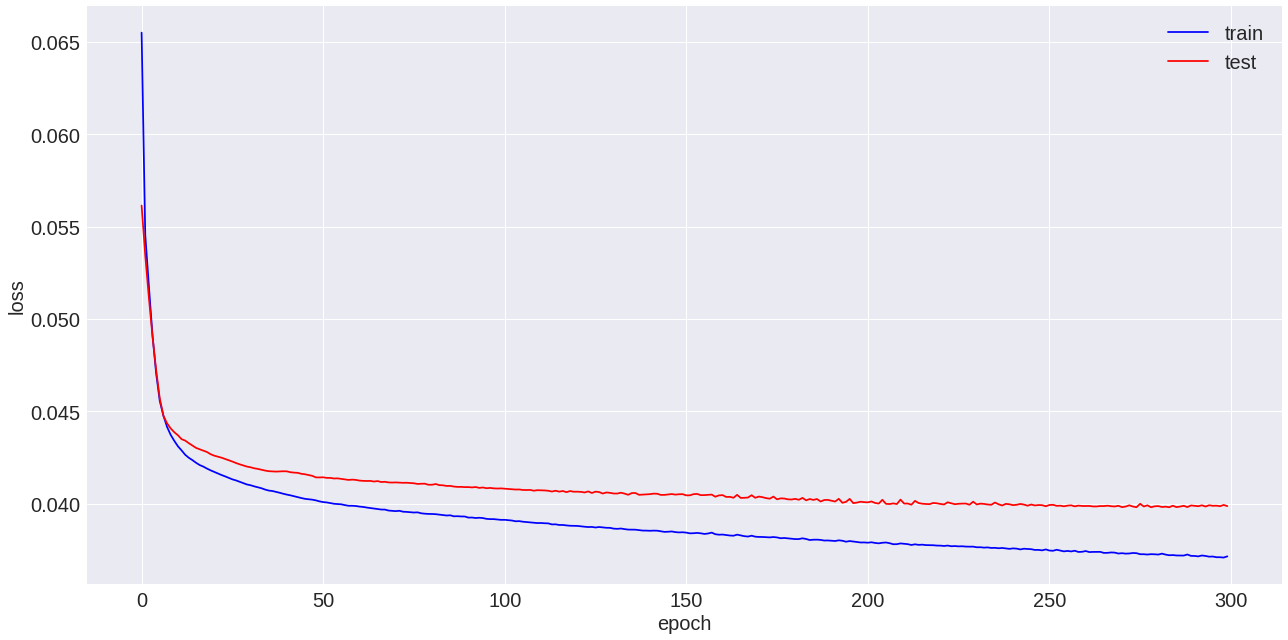

In [ ]:
# plot history
plt.style.use('seaborn')
plt.figure(figsize=(18,9))
pyplot.plot(history.history['loss'], label='train', color='blue')
pyplot.plot(history.history['val_loss'], label='test', color='red')
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss',fontsize=20) 
# plt.title('train and test loss evolution',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
pyplot.legend(fontsize=20)
pyplot.show()

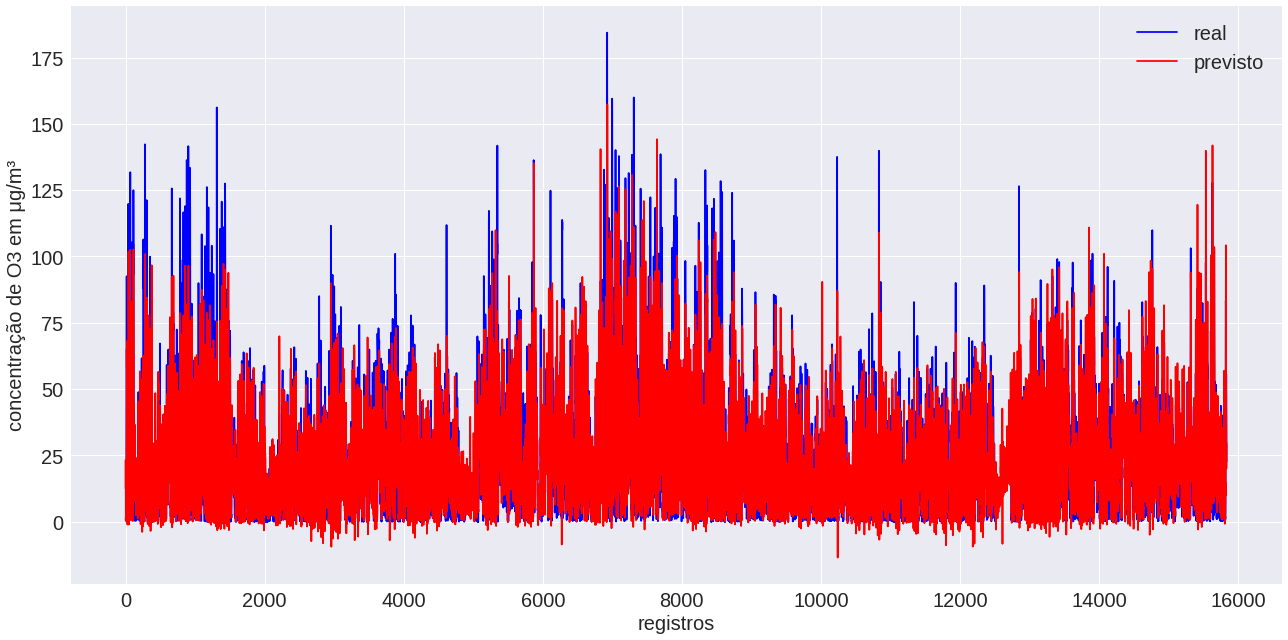

In [ ]:
# plot history
plt.style.use('seaborn')
plt.figure(figsize=(18,9))
pyplot.plot(inv_y, label='real', color='blue')
pyplot.plot(inv_yhat, label='previsto', color='red')
plt.xlabel('registros',fontsize=20)
plt.ylabel('concentração de O3 em μg/m³',fontsize=20) 
# plt.title('comparação: real vs previsto',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
pyplot.legend(fontsize=20)
pyplot.show()

#**(spline) LAG=4**

In [ ]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score #colocar citação

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

df_sc.drop(columns=['Ano','Mês','Dia','Hora','Hora-minuto'], inplace=True)
#df_sc.drop(columns=['Hora-minuto'], inplace=True)
df_sc_copy=df_sc.copy()
df_sc_copy=df_sc_copy[['O3']]
df_sc.drop(columns=['O3'],inplace=True)
df_sc = pd.concat([df_sc_copy,df_sc], axis=1, ignore_index=False)

values = df_sc.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# specify the number of lag hours
n_hours = 4
n_features = 10

# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 4)

# split into train and test sets
values = reframed.values
n_train_hours = 1855 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

# design network
opt = Adam(learning_rate=0.0005)
model = Sequential()
model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer=opt)

# fit network
history = model.fit(train_X, train_y, epochs=300, batch_size=500, validation_data=(test_X, test_y), verbose=2, shuffle=False)

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -9:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -9:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 16.279


In [ ]:
# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test MAE: 10.913


In [ ]:
# calculate R2
r2=r2_score(inv_y, inv_yhat)
print('Test R2: %.3f' % r2)

Test R2: 0.537


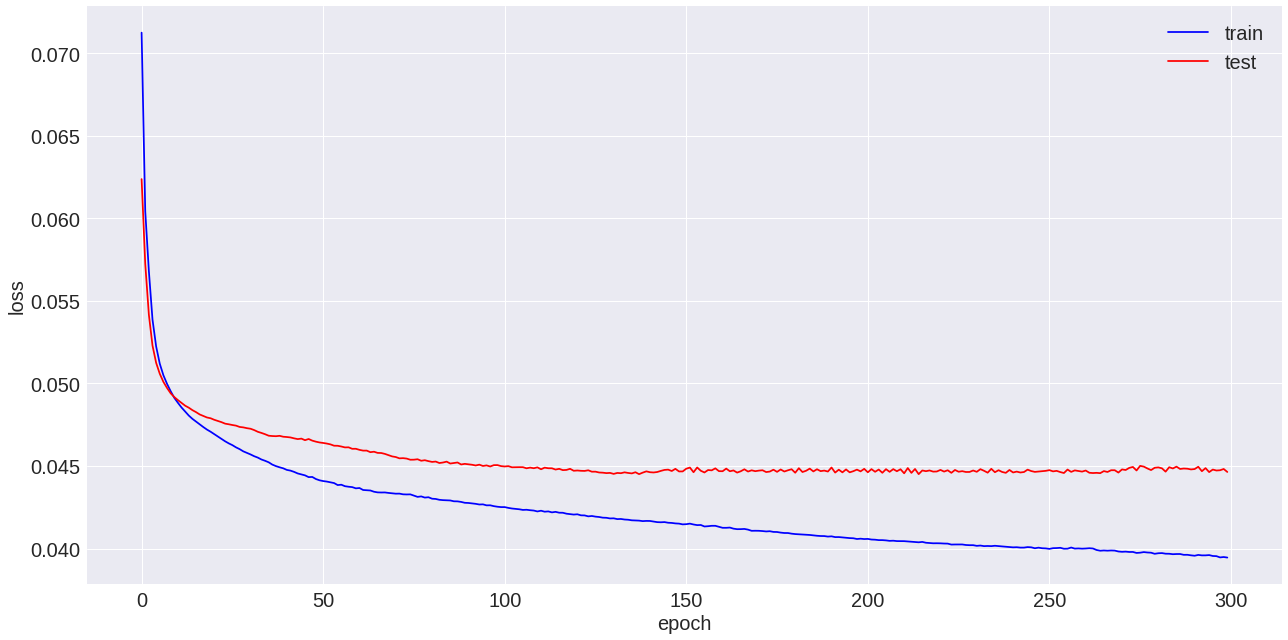

In [ ]:
# plot history
plt.style.use('seaborn')
plt.figure(figsize=(18,9))
pyplot.plot(history.history['loss'], label='train', color='blue')
pyplot.plot(history.history['val_loss'], label='test', color='red')
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss',fontsize=20) 
# plt.title('train and test loss evolution',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
pyplot.legend(fontsize=20)
pyplot.show()

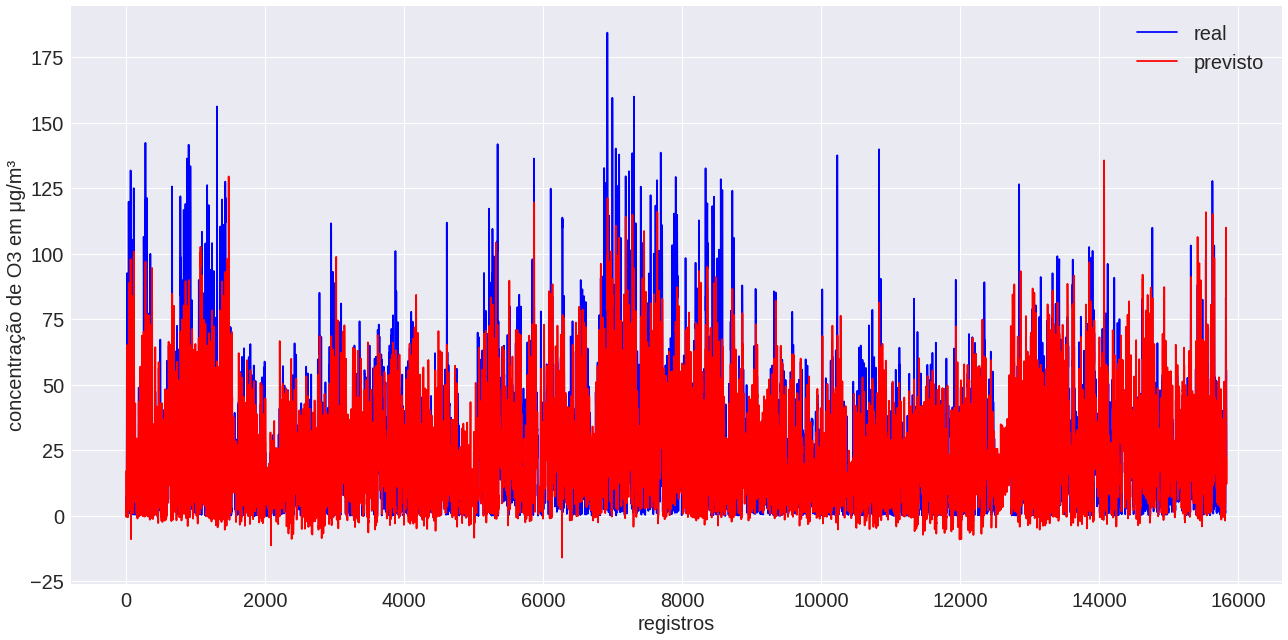

In [ ]:
# plot history
plt.style.use('seaborn')
plt.figure(figsize=(18,9))
pyplot.plot(inv_y, label='real', color='blue')
pyplot.plot(inv_yhat, label='previsto', color='red')
plt.xlabel('registros',fontsize=20)
plt.ylabel('concentração de O3 em μg/m³',fontsize=20) 
# plt.title('comparação: real vs previsto',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
pyplot.legend(fontsize=20)
pyplot.show()